In [1]:
import pandas as pd
import pathlib

RUTA = pathlib.Path(__vsc_ipynb_file__).parent.parent # type: ignore

df = pd.read_csv(f"{RUTA}/Data/Data2.csv", encoding='latin1', sep=',', on_bad_lines='skip')
df.shape

(1999889, 26)

In [2]:
df.head(5)

,Amount,Is_Fraud,IngresoAnual,DebitoTotal,FICO_Score,Year,Month,Time,LimiteCredito,Errors_Insufficient Balance,...,Dia_Semana_MiÃ©rcoles,Dia_Semana_SÃ¡bado,Dia_Semana_Viernes,BancoCredito_Amex,BancoCredito_Discover,BancoCredito_Mastercard,BancoCredito_Visa,TipoTarjeta_Credit,TipoTarjeta_Debit,TipoTarjeta_Debit (Prepaid)
0,0.870166,0,1.058518,-0.269604,0.217595,-4.105101,-1.592169,0.905811,1.531309,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.744696,0,1.058518,-0.269604,0.217595,-4.105101,-1.592169,-1.230862,1.531309,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.060533,0,1.058518,-0.269604,0.217595,-4.105101,-1.592169,-0.445224,1.531309,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.139404,0,1.058518,-0.269604,0.217595,-4.105101,-1.304044,-1.142108,1.531309,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.390713,0,1.058518,-0.269604,0.217595,-4.105101,-1.304044,-0.326885,1.531309,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [4]:
# Cargar datos
X = df.drop('Is_Fraud', axis=1)
y = df['Is_Fraud']


In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
# Aplicar SMOTE para sobremuestreo de la clase minoritaria
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [7]:
# Calcular scale_pos_weight
# Calcula el ratio entre las clases para usarlo en scale_pos_weight
import numpy as np
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)


In [8]:
ratio

798.9554285714286

In [9]:

from xgboost import XGBClassifier

# Definir los hiperparámetros a buscar
param_distributions = {
    'max_depth': np.arange(3, 7, 1),
    'learning_rate': np.linspace(0.01, 0.3, 5),
    'n_estimators': np.arange(100, 500, 100),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'scale_pos_weight': [1, ratio]
}

In [10]:
# Crear el modelo con scale_pos_weight
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

model = xgb.XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss')

# Configurar el Random Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                   n_iter=50, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2, random_state=42)


# Ajustar el modelo
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Userr\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01  , 0.0825, 0.155 , 0.2275, 0.3   ]),
                                        'max_depth': array([3, 4, 5, 6]),
                                        'n_estimators': array([100, 200, 300, 400]),
                                        'scale_pos_weight': [1,
                                                             798.9554285714286],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='roc_auc', verbose=2)

In [11]:

# Mejor conjunto de hiperparámetros
#los parametros cambian aleatoriamenete
print("Best parameters found: ", random_search.best_params_)
print("Best AUC-ROC score: ", random_search.best_score_)

Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.22749999999999998, 'colsample_bytree': 0.6}
Best AUC-ROC score:  0.8792287569466424


In [12]:
import xgboost as xgb
model = xgb.XGBClassifier(subsample= 1, scale_pos_weight= ratio, n_estimators= 400, max_depth= 5, learning_rate= 0.22749999999999998, colsample_bytree= 0.6, use_label_encoder=False, eval_metric='logloss')

#model = xgb.XGBClassifier(subsample= 0.7, scale_pos_weight= ratio, n_estimators= 200, max_depth= 6, learning_rate= 0.22749999999999998, colsample_bytree= 1, use_label_encoder=False, eval_metric='logloss')
#Entrenar el modelo

model.fit(X_train, y_train)

c:\Users\Userr\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22749999999999998, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = model.predict(X_test)

In [14]:
# Evaluar el modelo

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

[[578120  21097]
 [   405    345]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    599217
           1       0.02      0.46      0.03       750

    accuracy                           0.96    599967
   macro avg       0.51      0.71      0.51    599967
weighted avg       1.00      0.96      0.98    599967

AUC-ROC: 0.8689543576589671


In [15]:
# Identificando el procentual de error

from sklearn.metrics import mean_squared_error
from sklearn import metrics
error = mean_squared_error(y_test, y_pred)
print("Error porcentual : %f" % (error*100))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))

Error porcentual : 3.583864
Exactitud: 0.9641613622082548


In [16]:
#poner a prueba el modelo clf

RUTA = pathlib.Path(__vsc_ipynb_file__).parent.parent # type: ignore
DatosPrueba = pd.read_csv(f"{RUTA}/data/DatosVerificacion.csv", encoding='latin1', sep=',', on_bad_lines='skip')

In [17]:
XPrueba = DatosPrueba.drop('Is_Fraud', axis=1)
yPrueba = DatosPrueba['Is_Fraud']


In [18]:
Prediccion = model.predict(XPrueba)

In [20]:
#El conjunto de datos para prueba tiene 10 transacciones, 5 fraudulentas y 5 que no lo son, DatosPrueba =[1,1,1,1,1,0,0,0,0,,0]
Prediccion

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

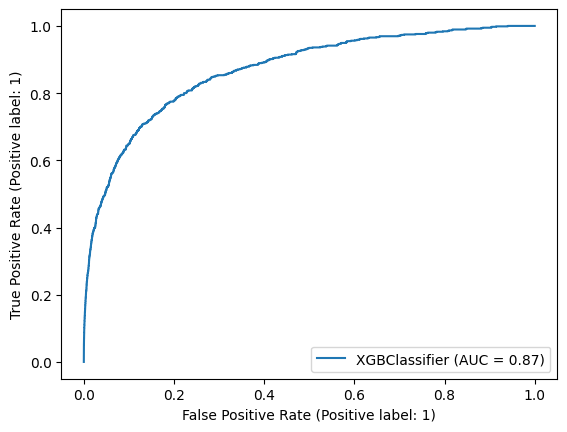

In [21]:
# graficamente como clasisfica el modelo

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()


In [22]:
#guaradar el modelo entrenado
import pickle

with open('modelo_xgboost.pkl', 'wb') as file:
    pickle.dump(model, file)

In [23]:
#llamar al modelo entrenado para hacer predicciones

import pickle

with open('modelo_xgboost.pkl', 'rb') as file:
    xgboost_model = pickle.load(file)

# Hacer predicciones
predicciones = xgboost_model.predict(XPrueba)

In [24]:
predicciones

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])